In [2]:
%pip install folktables

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\james\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
state_list = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
              'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
              'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
              'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
              'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']

In [ ]:
# Specify here which state and year the model should be trained (and tested) on
training_state = 'PA'
training_year = 2014
training_horizon = '1-Year'
#Specify here in which state and when the model should be deployed
deployment_state = 'PA'
deployment_year = 2018
deployment_horizon = '1-Year'

# Setup

## Get training and testing data

In [5]:
def preprocess_data(features, label, group):
  # Age
  ix_right_age_group = (features[:,0]>=25) & (features[:,0]<=65)
  features = features[ix_right_age_group]
  label = label[ix_right_age_group]
  group = group[ix_right_age_group]
  # Race
  ix_bw = (group==1) | (group==2)
  features = features[ix_bw]
  label = label[ix_bw]
  group = group[ix_bw]

  return (features, label, group)

In [6]:
from folktables import ACSDataSource, ACSEmployment
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

data_source = ACSDataSource(survey_year=training_year, horizon=training_horizon, survey='person')
acs_data = data_source.get_data(states=[training_state], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)
features, label, group = preprocess_data(features, label, group)

In [7]:
acs_data.to_csv("acs_data.csv")

### How successful are the job coaches?
Base rate: Probability of finding employment within the first year of working with the job coaches

In [8]:
np.mean(label)

np.float64(0.710184182015168)

## Train the model

In [9]:
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

model = make_pipeline(StandardScaler(), LogisticRegression())
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

## Make predictions

In [ ]:
yhat = model.predict(X_test)
scores = model.predict_proba(X_test)[:,1]

# Task 1: How good is the trained model?

In [11]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
from scipy import stats

In [12]:
# Calculate accuracy with standard threshold of 0.5
accuracy = accuracy_score(y_test, yhat)
print(f"Model accuracy: {accuracy:.4f}")

Model accuracy: 0.7650


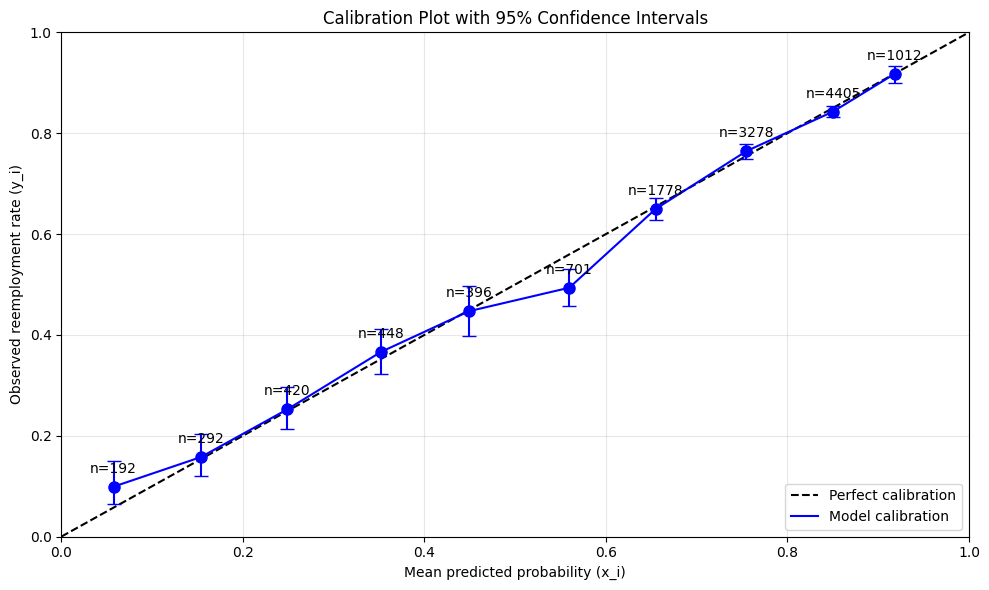

Bin	Range		Count	Avg Score (x_i)	Reemployment Rate (y_i)
1	[0.0, 0.1)	192	0.0574		0.0990
2	[0.1, 0.2)	292	0.1535		0.1575
3	[0.2, 0.3)	420	0.2490		0.2524
4	[0.3, 0.4)	448	0.3519		0.3661
5	[0.4, 0.5)	396	0.4491		0.4470
6	[0.5, 0.6)	701	0.5596		0.4936
7	[0.6, 0.7)	1778	0.6547		0.6496
8	[0.7, 0.8)	3278	0.7548		0.7645
9	[0.8, 0.9)	4405	0.8504		0.8429
10	[0.9, 1.0)	1012	0.9184		0.9180


In [ ]:
#calibration plot
from sklearn.calibration import calibration_curve

# Get predicted probabilities
y_prob = model.predict_proba(X_test)[:, 1]

# Create bins manually
bins = np.linspace(0, 1, 11)  # [0, 0.1, 0.2, ..., 0.9, 1]
bin_indices = np.digitize(y_prob, bins) - 1
bin_indices = np.clip(bin_indices, 0, 9)  # Ensure all indices are within range

# Calculate statistics for each bin
x_i = []  # Average score per bin
y_i = []  # Average reemployment rate per bin
counts = []  # Number of samples per bin
ci_lower = []  # Lower bound of 95% CI
ci_upper = []  # Upper bound of 95% CI

for i in range(10):
    # Get indices of samples in this bin
    mask = (bin_indices == i)
    count = np.sum(mask)
    
    if count > 0:
        # Average predicted score in this bin
        avg_score = np.mean(y_prob[mask])
        
        # Actual reemployment rate in this bin
        actual_rate = np.mean(y_test[mask])
        
        # Store values
        x_i.append(avg_score)
        y_i.append(actual_rate)
        counts.append(count)
        
        # Calculate 95% confidence interval (Wilson score interval)
        if count >= 5:
            z = 1.96  # z-score for 95% confidence
            n = count
            p = actual_rate
            
            # Wilson score interval formula
            denominator = 1 + z**2/n
            center = (p + z**2/(2*n))/denominator
            pm = z * np.sqrt(p*(1-p)/n + z**2/(4*n**2))/denominator
            
            ci_lower.append(max(0, center - pm))
            ci_upper.append(min(1, center + pm))
        else:
            ci_lower.append(0)
            ci_upper.append(1)

# Convert to numpy arrays for easier manipulation
x_i = np.array(x_i)
y_i = np.array(y_i)
counts = np.array(counts)
ci_lower = np.array(ci_lower)
ci_upper = np.array(ci_upper)

# Plot calibration curve
plt.figure(figsize=(10, 6))

# Plot perfect calibration line
plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')

# Plot calibration points with error bars
for i in range(len(x_i)):
    plt.errorbar(x_i[i], y_i[i], 
                yerr=[[y_i[i]-ci_lower[i]], [ci_upper[i]-y_i[i]]],
                fmt='o', capsize=5, color='blue', markersize=8)

# Connect the points
plt.plot(x_i, y_i, 'b-', label='Model calibration')

# Add sample counts as annotations
for i in range(len(x_i)):
    plt.annotate(f'n={counts[i]}', 
                (x_i[i], y_i[i]),
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center')

# Formatting
plt.xlabel('Mean predicted probability (x_i)')
plt.ylabel('Observed reemployment rate (y_i)')
plt.title('Calibration Plot with 95% Confidence Intervals')
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

# Print the bin statistics
print("Bin\tRange\t\tCount\tAvg Score (x_i)\tReemployment Rate (y_i)")
for i in range(10):
    bin_range = f"[{bins[i]:.1f}, {bins[i+1]:.1f})"
    bin_mask = (bin_indices == i)
    count = np.sum(bin_mask)
    
    if count > 0:
        avg_score = np.mean(y_prob[bin_mask])
        actual_rate = np.mean(y_test[bin_mask])
        print(f"{i+1}\t{bin_range}\t{count}\t{avg_score:.4f}\t\t{actual_rate:.4f}")
    else:
        print(f"{i+1}\t{bin_range}\t0\t-\t\t-")



# Task 2: How well does the model work for the two groups?

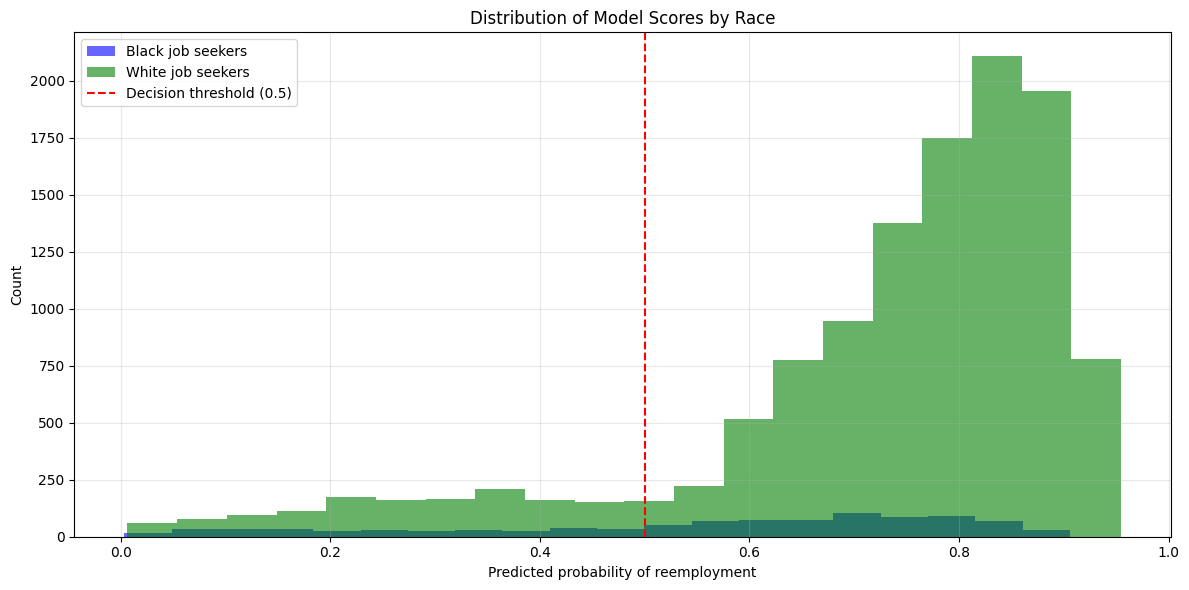

Summary Statistics:
Black job seekers (n=971):
  Mean score: 0.5532
  Median score: 0.6184
  % above threshold: 66.63%
  Actual reemployment rate: 53.76%

White job seekers (n=11951):
  Mean score: 0.7250
  Median score: 0.7825
  % above threshold: 88.08%
  Actual reemployment rate: 72.29%

Performance Metrics for Black job seekers:
  Accuracy: 0.7168
  Precision: 0.6909
  Recall: 0.8563
  F1 Score: 0.7648

Performance Metrics for White job seekers:
  Accuracy: 0.7689
  Precision: 0.7791
  Recall: 0.9494
  F1 Score: 0.8559


In [14]:
# Distribution score plot
# Extract race information from the group variable
is_black = (group_test == 2)  # Black or African American alone
is_white = (group_test == 1)  # White alone

# Get predicted probabilities for each group
X_test_black = X_test[is_black]
X_test_white = X_test[is_white]
y_prob_black = model.predict_proba(X_test_black)[:, 1]
y_prob_white = model.predict_proba(X_test_white)[:, 1]

# Get actual outcomes for each group
y_test_black = y_test[is_black]
y_test_white = y_test[is_white]

# Plot the score distributions
plt.figure(figsize=(12, 6))

# Create histograms
plt.hist(y_prob_black, bins=20, alpha=0.6, color='blue', label='Black job seekers')
plt.hist(y_prob_white, bins=20, alpha=0.6, color='green', label='White job seekers')

# Add vertical line at threshold 0.5
plt.axvline(x=0.5, color='red', linestyle='--', label='Decision threshold (0.5)')

# Add labels and title
plt.xlabel('Predicted probability of reemployment')
plt.ylabel('Count')
plt.title('Distribution of Model Scores by Race')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate and print summary statistics
print("Summary Statistics:")
print(f"Black job seekers (n={len(y_prob_black)}):")
print(f"  Mean score: {np.mean(y_prob_black):.4f}")
print(f"  Median score: {np.median(y_prob_black):.4f}")
print(f"  % above threshold: {np.mean(y_prob_black >= 0.5)*100:.2f}%")
print(f"  Actual reemployment rate: {np.mean(y_test_black)*100:.2f}%")
print()
print(f"White job seekers (n={len(y_prob_white)}):")
print(f"  Mean score: {np.mean(y_prob_white):.4f}")
print(f"  Median score: {np.median(y_prob_white):.4f}")
print(f"  % above threshold: {np.mean(y_prob_white >= 0.5)*100:.2f}%")
print(f"  Actual reemployment rate: {np.mean(y_test_white)*100:.2f}%")

# Calculate performance metrics for each group
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get binary predictions using 0.5 threshold
y_pred_black = (y_prob_black >= 0.5).astype(int)
y_pred_white = (y_prob_white >= 0.5).astype(int)

# Function to calculate and display metrics
def print_metrics(y_true, y_pred, group_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\nPerformance Metrics for {group_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")

# Print metrics for each group
print_metrics(y_test_black, y_pred_black, "Black job seekers")
print_metrics(y_test_white, y_pred_white, "White job seekers")


Statistical comparison of reemployment rates by bin:
--------------------------------------------------------------------------------
Bin  Range       Black Rate     White Rate     p-value        Significant    
--------------------------------------------------------------------------------
1    [0.0, 0.1)  0.1404     0.0815     0.2120         No             
2    [0.1, 0.2)  0.1429     0.1622     0.6991         No             
3    [0.2, 0.3)  0.3051     0.2438     0.3148         No             
4    [0.3, 0.4)  0.2258     0.3886     0.0135         Yes            
5    [0.4, 0.5)  0.3289     0.4750     0.0213         Yes            
6    [0.5, 0.6)  0.4701     0.4991     0.5464         No             
7    [0.6, 0.7)  0.5989     0.6552     0.1360         No             
8    [0.7, 0.8)  0.8047     0.7617     0.1511         No             
9    [0.8, 0.9)  0.8729     0.8421     0.3644         No             
10   [0.9, 1.0)  0.6667     0.9187     N/A            Insufficient data
-----

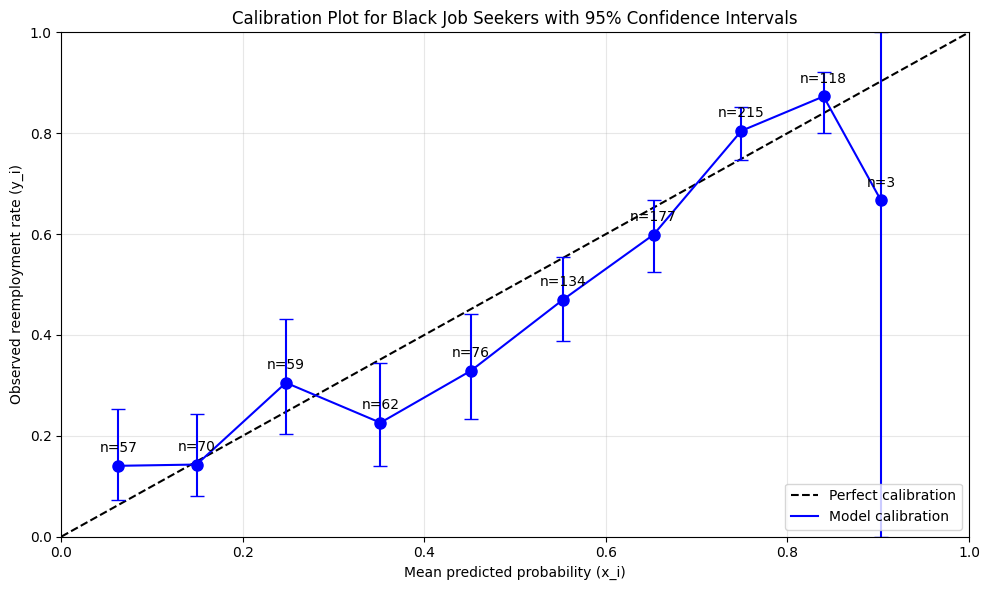

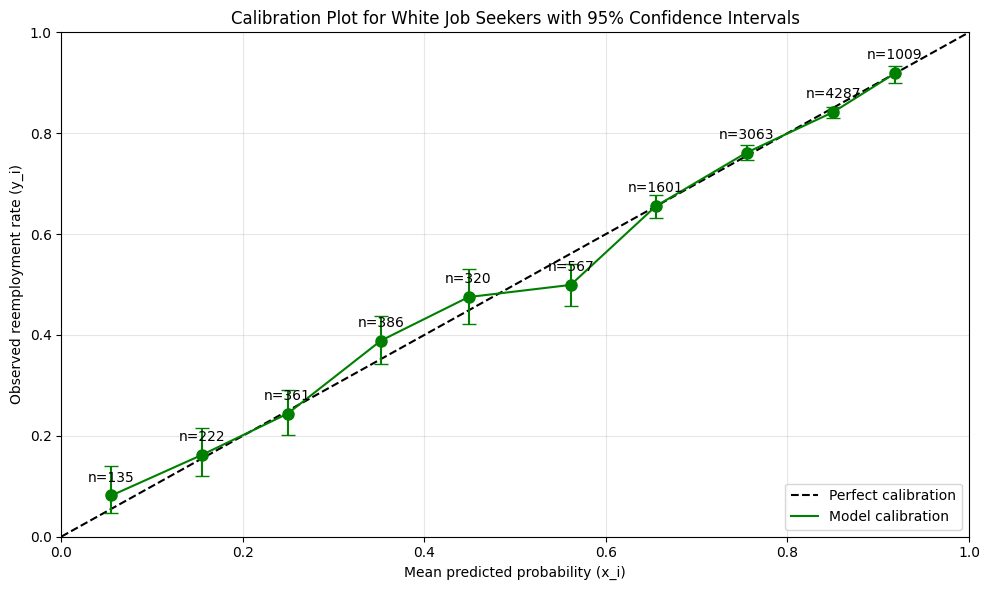


Bin statistics for Black job seekers:
Bin	Range		Count	Avg Score (x_i)	Reemployment Rate (y_i)
1	[0.0, 0.1)	57	0.0629		0.1404
2	[0.1, 0.2)	70	0.1489		0.1429
3	[0.2, 0.3)	59	0.2474		0.3051
4	[0.3, 0.4)	62	0.3515		0.2258
5	[0.4, 0.5)	76	0.4512		0.3289
6	[0.5, 0.6)	134	0.5529		0.4701
7	[0.6, 0.7)	177	0.6525		0.5989
8	[0.7, 0.8)	215	0.7492		0.8047
9	[0.8, 0.9)	118	0.8397		0.8729
10	[0.9, 1.0)	3	0.9030		0.6667

Bin statistics for White job seekers:
Bin	Range		Count	Avg Score (x_i)	Reemployment Rate (y_i)
1	[0.0, 0.1)	135	0.0551		0.0815
2	[0.1, 0.2)	222	0.1550		0.1622
3	[0.2, 0.3)	361	0.2492		0.2438
4	[0.3, 0.4)	386	0.3520		0.3886
5	[0.4, 0.5)	320	0.4486		0.4750
6	[0.5, 0.6)	567	0.5612		0.4991
7	[0.6, 0.7)	1601	0.6549		0.6552
8	[0.7, 0.8)	3063	0.7552		0.7617
9	[0.8, 0.9)	4287	0.8506		0.8421
10	[0.9, 1.0)	1009	0.9185		0.9187


In [15]:
# Calibration analysis by race
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Get predicted probabilities for each group
y_prob_black = model.predict_proba(X_test[is_black])[:, 1]
y_prob_white = model.predict_proba(X_test[is_white])[:, 1]

# Get actual outcomes for each group
y_test_black = y_test[is_black]
y_test_white = y_test[is_white]

# Create bins
bins = np.linspace(0, 1, 11)  # [0, 0.1, 0.2, ..., 0.9, 1]
bin_indices_black = np.digitize(y_prob_black, bins) - 1
bin_indices_white = np.digitize(y_prob_white, bins) - 1

# Ensure all indices are within range
bin_indices_black = np.clip(bin_indices_black, 0, 9)
bin_indices_white = np.clip(bin_indices_white, 0, 9)

# Function to calculate statistics for each bin
def calculate_bin_stats(y_prob, y_true, bin_indices):
    x_i = []  # Average score per bin
    y_i = []  # Average reemployment rate per bin
    counts = []  # Number of samples per bin
    ci_lower = []  # Lower bound of 95% CI
    ci_upper = []  # Upper bound of 95% CI
    
    for i in range(10):
        # Get indices of samples in this bin
        mask = (bin_indices == i)
        count = np.sum(mask)
        
        if count > 0:
            # Average predicted score in this bin
            avg_score = np.mean(y_prob[mask])
            
            # Actual reemployment rate in this bin
            actual_rate = np.mean(y_true[mask])
            
            # Store values
            x_i.append(avg_score)
            y_i.append(actual_rate)
            counts.append(count)
            
            # Calculate 95% confidence interval (Wilson score interval)
            if count >= 5:
                z = 1.96  # z-score for 95% confidence
                n = count
                p = actual_rate
                
                # Wilson score interval formula
                denominator = 1 + z**2/n
                center = (p + z**2/(2*n))/denominator
                pm = z * np.sqrt(p*(1-p)/n + z**2/(4*n**2))/denominator
                
                ci_lower.append(max(0, center - pm))
                ci_upper.append(min(1, center + pm))
            else:
                ci_lower.append(0)
                ci_upper.append(1)
        else:
            x_i.append(i * 0.1 + 0.05)  # Midpoint of bin
            y_i.append(np.nan)
            counts.append(0)
            ci_lower.append(np.nan)
            ci_upper.append(np.nan)
    
    return np.array(x_i), np.array(y_i), np.array(counts), np.array(ci_lower), np.array(ci_upper)

# Calculate statistics for each group
x_i_black, y_i_black, counts_black, ci_lower_black, ci_upper_black = calculate_bin_stats(y_prob_black, y_test_black, bin_indices_black)
x_i_white, y_i_white, counts_white, ci_lower_white, ci_upper_white = calculate_bin_stats(y_prob_white, y_test_white, bin_indices_white)

# Function to perform two-proportion z-test manually
def two_proportion_z_test(count1, n1, count2, n2):
    """
    Perform a two-proportion z-test
    
    Parameters:
    count1 (int): Number of successes in first sample
    n1 (int): Size of first sample
    count2 (int): Number of successes in second sample
    n2 (int): Size of second sample
    
    Returns:
    float: p-value for two-tailed test
    """
    p1 = count1 / n1
    p2 = count2 / n2
    p_pooled = (count1 + count2) / (n1 + n2)
    
    # Standard error
    se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))
    
    # Z-statistic
    z = (p1 - p2) / se
    
    # Two-tailed p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    return p_value

# Check for statistically significant differences in each bin
print("Statistical comparison of reemployment rates by bin:")
print("-" * 80)
print(f"{'Bin':<5}{'Range':<12}{'Black Rate':<15}{'White Rate':<15}{'p-value':<15}{'Significant':<15}")
print("-" * 80)

for i in range(10):
    bin_range = f"[{bins[i]:.1f}, {bins[i+1]:.1f})"
    
    # Get samples in this bin for each group
    black_mask = (bin_indices_black == i)
    white_mask = (bin_indices_white == i)
    
    black_count = np.sum(black_mask)
    white_count = np.sum(white_mask)
    
    if black_count > 0 and white_count > 0:
        black_rate = np.mean(y_test_black[black_mask])
        white_rate = np.mean(y_test_white[white_mask])
        
        # Perform statistical test (two-proportion z-test)
        count_black_success = np.sum(y_test_black[black_mask])
        count_white_success = np.sum(y_test_white[white_mask])
        
        # Only perform test if we have enough samples
        if black_count >= 5 and white_count >= 5:
            p_value = two_proportion_z_test(
                count_black_success, black_count,
                count_white_success, white_count
            )
            significant = "Yes" if p_value < 0.05 else "No"
            p_value_str = f"{p_value:.4f}"
        else:
            p_value_str = "N/A"
            significant = "Insufficient data"
        
        print(f"{i+1:<5}{bin_range:<12}{black_rate:.4f}{'':5}{white_rate:.4f}{'':5}{p_value_str:<15}{significant:<15}")
    else:
        if black_count == 0 and white_count == 0:
            print(f"{i+1:<5}{bin_range:<12}{'No data':<15}{'No data':<15}{'-':<15}{'-':<15}")
        elif black_count == 0:
            white_rate = np.mean(y_test_white[white_mask])
            print(f"{i+1:<5}{bin_range:<12}{'No data':<15}{white_rate:.4f}{'':5}{'-':<15}{'-':<15}")
        else:
            black_rate = np.mean(y_test_black[black_mask])
            print(f"{i+1:<5}{bin_range:<12}{black_rate:.4f}{'':5}{'No data':<15}{'-':<15}{'-':<15}")
print("-" * 80)


# Create two separate plots, one for each racial group
# Plot for Black job seekers
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')

# Plot calibration points with error bars for Black job seekers
for i in range(len(x_i_black)):
    if counts_black[i] > 0:
        plt.errorbar(x_i_black[i], y_i_black[i], 
                    yerr=[[y_i_black[i]-ci_lower_black[i]], [ci_upper_black[i]-y_i_black[i]]],
                    fmt='o', capsize=5, color='blue', markersize=8)

# Connect the points for Black job seekers
valid_black = ~np.isnan(y_i_black)
plt.plot(x_i_black[valid_black], y_i_black[valid_black], 'b-', label='Model calibration')

# Add sample counts as annotations
for i in range(len(x_i_black)):
    if counts_black[i] > 0:
        plt.annotate(f'n={counts_black[i]}', 
                    (x_i_black[i], y_i_black[i]),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')

# Formatting
plt.xlabel('Mean predicted probability (x_i)')
plt.ylabel('Observed reemployment rate (y_i)')
plt.title('Calibration Plot for Black Job Seekers with 95% Confidence Intervals')
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

# Plot for White job seekers
plt.figure(figsize=(10, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')

# Plot calibration points with error bars for White job seekers
for i in range(len(x_i_white)):
    if counts_white[i] > 0:
        plt.errorbar(x_i_white[i], y_i_white[i], 
                    yerr=[[y_i_white[i]-ci_lower_white[i]], [ci_upper_white[i]-y_i_white[i]]],
                    fmt='o', capsize=5, color='green', markersize=8)

# Connect the points for White job seekers
valid_white = ~np.isnan(y_i_white)
plt.plot(x_i_white[valid_white], y_i_white[valid_white], 'g-', label='Model calibration')

# Add sample counts as annotations
for i in range(len(x_i_white)):
    if counts_white[i] > 0:
        plt.annotate(f'n={counts_white[i]}', 
                    (x_i_white[i], y_i_white[i]),
                    textcoords="offset points", 
                    xytext=(0,10), 
                    ha='center')

# Formatting
plt.xlabel('Mean predicted probability (x_i)')
plt.ylabel('Observed reemployment rate (y_i)')
plt.title('Calibration Plot for White Job Seekers with 95% Confidence Intervals')
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.tight_layout()
plt.show()

# Print the bin statistics for each group
print("\nBin statistics for Black job seekers:")
print("Bin\tRange\t\tCount\tAvg Score (x_i)\tReemployment Rate (y_i)")
for i in range(10):
    bin_range = f"[{bins[i]:.1f}, {bins[i+1]:.1f})"
    if counts_black[i] > 0:
        print(f"{i+1}\t{bin_range}\t{counts_black[i]}\t{x_i_black[i]:.4f}\t\t{y_i_black[i]:.4f}")
    else:
        print(f"{i+1}\t{bin_range}\t0\t-\t\t-")

print("\nBin statistics for White job seekers:")
print("Bin\tRange\t\tCount\tAvg Score (x_i)\tReemployment Rate (y_i)")
for i in range(10):
    bin_range = f"[{bins[i]:.1f}, {bins[i+1]:.1f})"
    if counts_white[i] > 0:
        print(f"{i+1}\t{bin_range}\t{counts_white[i]}\t{x_i_white[i]:.4f}\t\t{y_i_white[i]:.4f}")
    else:
        print(f"{i+1}\t{bin_range}\t0\t-\t\t-")


Fairness Metrics Comparison Between Racial Groups
Metric    Black       White       Difference  p-value     Significant 
----------------------------------------------------------------------------------------------------
BR        0.5376      0.7229      -0.1853     0.0000      Yes         
PR        0.6663      0.8808      -0.2145     0.0000      Yes         
TPR       0.8563      0.9494      -0.0931     0.0000      Yes         
FNR       0.1437      0.0506      0.0931      0.0000      Yes         
FPR       0.4454      0.7020      -0.2566     0.0000      Yes         
TNR       0.5546      0.2980      0.2566      0.0000      Yes         
----------------------------------------------------------------------------------------------------
Sample sizes: Black = 971, White = 11951


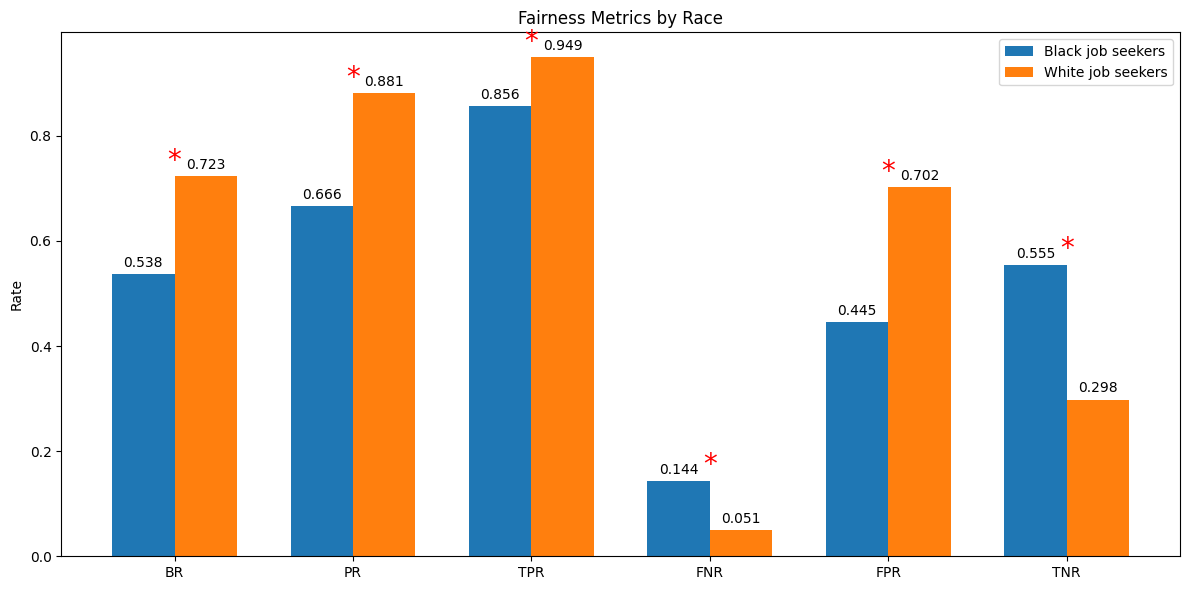


Interpretation of Fairness Metrics:
--------------------------------------------------------------------------------
1. Base Rate (BR): The actual reemployment rate is 0.1853 lower for Black job seekers
   compared to White job seekers (0.5376 vs 0.7229).
   This difference is statistically significant.

2. Positive Rate (PR): The model predicts reemployment 0.2145 lower for Black job seekers
   compared to White job seekers (0.6663 vs 0.8808).
   This difference is statistically significant.

3. True Positive Rate (TPR): The model correctly identifies 0.0931 lower proportion of
   actual reemployed individuals among Black job seekers compared to White job seekers
   (0.8563 vs 0.9494).
   This difference is statistically significant.

4. False Negative Rate (FNR): The model incorrectly predicts non-reemployment 0.0931 higher
   for actually reemployed Black job seekers compared to White job seekers
   (0.1437 vs 0.0506).
   This difference is statistically significant.

5. False Posi

In [16]:
# Fairness metrics comparison between racial groups
import numpy as np
from scipy import stats

# Get predicted probabilities and binary predictions
y_prob_black = model.predict_proba(X_test[is_black])[:, 1]
y_prob_white = model.predict_proba(X_test[is_white])[:, 1]

# Binary predictions using 0.5 threshold
y_pred_black = (y_prob_black >= 0.5).astype(int)
y_pred_white = (y_prob_white >= 0.5).astype(int)

# Actual outcomes
y_true_black = y_test[is_black]
y_true_white = y_test[is_white]

# Function to calculate fairness metrics
def calculate_metrics(y_true, y_pred):
    # Base Rate (BR): Proportion of positive outcomes in the data
    BR = np.mean(y_true)
    
    # Positive Rate (PR): Proportion of positive predictions
    PR = np.mean(y_pred)
    
    # True Positive Rate (TPR) / Sensitivity / Recall: Proportion of actual positives correctly identified
    TPR = np.sum((y_true == 1) & (y_pred == 1)) / np.sum(y_true == 1) if np.sum(y_true == 1) > 0 else 0
    
    # False Negative Rate (FNR): Proportion of actual positives incorrectly identified as negative
    FNR = np.sum((y_true == 1) & (y_pred == 0)) / np.sum(y_true == 1) if np.sum(y_true == 1) > 0 else 0
    
    # False Positive Rate (FPR): Proportion of actual negatives incorrectly identified as positive
    FPR = np.sum((y_true == 0) & (y_pred == 1)) / np.sum(y_true == 0) if np.sum(y_true == 0) > 0 else 0
    
    # True Negative Rate (TNR) / Specificity: Proportion of actual negatives correctly identified
    TNR = np.sum((y_true == 0) & (y_pred == 0)) / np.sum(y_true == 0) if np.sum(y_true == 0) > 0 else 0
    
    return {
        'BR': BR,
        'PR': PR,
        'TPR': TPR,
        'FNR': FNR,
        'FPR': FPR,
        'TNR': TNR
    }

# Calculate metrics for each group
metrics_black = calculate_metrics(y_true_black, y_pred_black)
metrics_white = calculate_metrics(y_true_white, y_pred_white)

# Function to perform statistical test for difference in proportions
def proportion_test(p1, n1, p2, n2):
    """
    Perform a two-proportion z-test
    
    Parameters:
    p1 (float): Proportion in first sample
    n1 (int): Size of first sample
    p2 (float): Proportion in second sample
    n2 (int): Size of second sample
    
    Returns:
    tuple: (z-statistic, p-value, is_significant)
    """
    # Pooled proportion
    p_pooled = (p1 * n1 + p2 * n2) / (n1 + n2)
    
    # Standard error
    se = np.sqrt(p_pooled * (1 - p_pooled) * (1/n1 + 1/n2))
    
    # Z-statistic
    z = (p1 - p2) / se if se > 0 else 0
    
    # Two-tailed p-value
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))
    
    # Check if significant at 0.05 level
    is_significant = p_value < 0.05
    
    return z, p_value, is_significant

# Sample sizes
n_black = len(y_true_black)
n_white = len(y_true_white)

# Perform statistical tests for each metric
test_results = {}
for metric in metrics_black.keys():
    z, p_value, is_significant = proportion_test(
        metrics_black[metric], n_black,
        metrics_white[metric], n_white
    )
    test_results[metric] = {
        'z': z,
        'p_value': p_value,
        'is_significant': is_significant
    }

# Print results in a nicely formatted table
print("Fairness Metrics Comparison Between Racial Groups")
print("=" * 100)
print(f"{'Metric':<10}{'Black':<12}{'White':<12}{'Difference':<12}{'p-value':<12}{'Significant':<12}")
print("-" * 100)

for metric in metrics_black.keys():
    black_value = metrics_black[metric]
    white_value = metrics_white[metric]
    difference = black_value - white_value
    p_value = test_results[metric]['p_value']
    is_significant = "Yes" if test_results[metric]['is_significant'] else "No"
    
    print(f"{metric:<10}{black_value:<12.4f}{white_value:<12.4f}{difference:<12.4f}{p_value:<12.4f}{is_significant:<12}")

print("-" * 100)
print(f"Sample sizes: Black = {n_black}, White = {n_white}")
print("=" * 100)


# Create a bar chart to visualize the metrics
import matplotlib.pyplot as plt

metrics = list(metrics_black.keys())
black_values = [metrics_black[m] for m in metrics]
white_values = [metrics_white[m] for m in metrics]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, black_values, width, label='Black job seekers')
rects2 = ax.bar(x + width/2, white_values, width, label='White job seekers')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Rate')
ax.set_title('Fairness Metrics by Race')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Add asterisks for statistically significant differences
for i, metric in enumerate(metrics):
    if test_results[metric]['is_significant']:
        ax.text(i, max(black_values[i], white_values[i]) + 0.03, '*', 
                ha='center', va='center', fontsize=20, color='red')

fig.tight_layout()
plt.show()

# Provide interpretation of the results
print("\nInterpretation of Fairness Metrics:")
print("-" * 80)

# Base Rate interpretation
br_diff = metrics_black['BR'] - metrics_white['BR']
br_sign = "higher" if br_diff > 0 else "lower"
print(f"1. Base Rate (BR): The actual reemployment rate is {abs(br_diff):.4f} {br_sign} for Black job seekers")
print(f"   compared to White job seekers ({metrics_black['BR']:.4f} vs {metrics_white['BR']:.4f}).")
if test_results['BR']['is_significant']:
    print("   This difference is statistically significant.")
else:
    print("   This difference is not statistically significant.")

# Positive Rate interpretation
pr_diff = metrics_black['PR'] - metrics_white['PR']
pr_sign = "higher" if pr_diff > 0 else "lower"
print(f"\n2. Positive Rate (PR): The model predicts reemployment {abs(pr_diff):.4f} {pr_sign} for Black job seekers")
print(f"   compared to White job seekers ({metrics_black['PR']:.4f} vs {metrics_white['PR']:.4f}).")
if test_results['PR']['is_significant']:
    print("   This difference is statistically significant.")
else:
    print("   This difference is not statistically significant.")

# True Positive Rate interpretation
tpr_diff = metrics_black['TPR'] - metrics_white['TPR']
tpr_sign = "higher" if tpr_diff > 0 else "lower"
print(f"\n3. True Positive Rate (TPR): The model correctly identifies {abs(tpr_diff):.4f} {tpr_sign} proportion of")
print(f"   actual reemployed individuals among Black job seekers compared to White job seekers")
print(f"   ({metrics_black['TPR']:.4f} vs {metrics_white['TPR']:.4f}).")
if test_results['TPR']['is_significant']:
    print("   This difference is statistically significant.")
else:
    print("   This difference is not statistically significant.")

# False Negative Rate interpretation
fnr_diff = metrics_black['FNR'] - metrics_white['FNR']
fnr_sign = "higher" if fnr_diff > 0 else "lower"
print(f"\n4. False Negative Rate (FNR): The model incorrectly predicts non-reemployment {abs(fnr_diff):.4f} {fnr_sign}")
print(f"   for actually reemployed Black job seekers compared to White job seekers")
print(f"   ({metrics_black['FNR']:.4f} vs {metrics_white['FNR']:.4f}).")
if test_results['FNR']['is_significant']:
    print("   This difference is statistically significant.")
else:
    print("   This difference is not statistically significant.")

# False Positive Rate interpretation
fpr_diff = metrics_black['FPR'] - metrics_white['FPR']
fpr_sign = "higher" if fpr_diff > 0 else "lower"
print(f"\n5. False Positive Rate (FPR): The model incorrectly predicts reemployment {abs(fpr_diff):.4f} {fpr_sign}")
print(f"   for actually non-reemployed Black job seekers compared to White job seekers")
print(f"   ({metrics_black['FPR']:.4f} vs {metrics_white['FPR']:.4f}).")
if test_results['FPR']['is_significant']:
    print("   This difference is statistically significant.")
else:
    print("   This difference is not statistically significant.")

# True Negative Rate interpretation
tnr_diff = metrics_black['TNR'] - metrics_white['TNR']
tnr_sign = "higher" if tnr_diff > 0 else "lower"
print(f"\n6. True Negative Rate (TNR): The model correctly identifies {abs(tnr_diff):.4f} {tnr_sign} proportion of")
print(f"   actual non-reemployed individuals among Black job seekers compared to White job seekers")
print(f"   ({metrics_black['TNR']:.4f} vs {metrics_white['TNR']:.4f}).")
if test_results['TNR']['is_significant']:
    print("   This difference is statistically significant.")
else:
    print("   This difference is not statistically significant.")

# Overall fairness assessment
print("\nOverall Fairness Assessment:")
print("-" * 80)
significant_metrics = [m for m in metrics_black.keys() if test_results[m]['is_significant']]
if len(significant_metrics) > 0:
    print(f"The model shows statistically significant differences between racial groups in the following metrics:")
    for metric in significant_metrics:
        print(f"- {metric}")
    
    # Check for specific fairness violations
    if 'TPR' in significant_metrics or 'FNR' in significant_metrics:
        print("\nEqual Opportunity: VIOLATED")
        print("The model has different true positive rates (or false negative rates) across racial groups,")
        print("meaning it has different error rates for people who actually get reemployed.")
    else:
        print("\nEqual Opportunity: SATISFIED")
    
    if 'FPR' in significant_metrics or 'TNR' in significant_metrics:
        print("\nPredictive Equality: VIOLATED")
        print("The model has different false positive rates (or true negative rates) across racial groups,")
        print("meaning it has different error rates for people who don't actually get reemployed.")
    else:
        print("\nPredictive Equality: SATISFIED")
    
    if 'PR' in significant_metrics:
        print("\nStatistical Parity: VIOLATED")
        print("The model predicts reemployment at different rates across racial groups,")
        print("regardless of the actual reemployment rates.")
    else:
        print("\nStatistical Parity: SATISFIED")
else:
    print("The model shows no statistically significant differences between racial groups in any of the metrics.")
    print("This suggests the model is fair across racial groups according to these metrics.")


# Task 3: Utility of the decision maker

In [ ]:
# Define the corrected utility matrix
utility_matrix = np.array([
    [-60000, -60000],  # D=0 (No coaching)
    [-80000, -50000]   # D=1 (Provide coaching)
])

# Display the utility matrix
print("Utility Matrix for Unemployment Agency (in CHF)")
print("=" * 60)
print(f"{'':20} | {'Y=0 (No employment)':25} | {'Y=1 (Employment)':25}")
print("-" * 60)
print(f"{'D=0 (No coaching)':20} | {utility_matrix[0,0]:25} | {utility_matrix[0,1]:25}")
print(f"{'D=1 (Provide coaching)':20} | {utility_matrix[1,0]:25} | {utility_matrix[1,1]:25}")
print("=" * 60)

# Hypothetical explanation for the public
print("\nExplanation to the Public:")
print("-" * 60)
print("Our utility matrix represents the costs to taxpayers for each decision outcome:")
print("\n1. When we don't provide job coaching:")
print("   - If the person remains unemployed: We pay CHF 60,000 in benefits over two years.")
print("   - If the person would have found employment with coaching: We also pay CHF 60,000 in benefits.")
print("\n2. When we provide job coaching (costing CHF 20,000 per person):")
print("   - If the person doesn't find employment: We pay CHF 80,000 (coaching costs plus two years of benefits).")
print("   - If the person finds employment: We pay CHF 50,000 (coaching costs plus one year of benefits).")
print("\nOur goal is to minimize total costs while helping people return to work.")
print("-" * 60)



# Calculate the optimal threshold theoretically
# The threshold is where the expected utilities are equal
theoretical_threshold = float((utility_matrix[1,0] - utility_matrix[0,0]) / (
    (utility_matrix[0,1] - utility_matrix[1,1]) - (utility_matrix[0,0] - utility_matrix[1,0])
))

print(f"\nTheoretical Optimal Threshold: {theoretical_threshold:.4f}")
print("This means we should provide job coaching to longtime unemployed people with a")
print(f"predicted probability of finding employment greater than {theoretical_threshold:.2%}")

# Find the empirical optimal threshold using the test data
thresholds = np.linspace(0, 1, 101)  # 0, 0.01, 0.02, ..., 0.99, 1
best_utility = float('-inf')
best_threshold = 0

# Get predicted probabilities for all test samples
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate utility for each threshold
for threshold in thresholds:
    # Make decisions based on this threshold
    decisions = (y_prob >= threshold).astype(int)
    
    # Calculate total utility
    total_utility = 0.0  # Start with Python float
    for i in range(len(y_test)):
        d = int(decisions[i])  # Convert to Python int
        y = int(y_test[i])     # Convert to Python int
        total_utility += float(utility_matrix[d, y])  # Convert to Python float
    
    # Check if this is the best utility so far
    if total_utility > best_utility:
        best_utility = total_utility
        best_threshold = float(threshold)  # Convert to Python float

print(f"\nEmpirical Optimal Threshold: {best_threshold:.4f}")
print(f"Total Utility at this threshold: CHF {best_utility:,.2f}")

# Compare decisions at default (0.5) vs. optimal threshold
default_decisions = (y_prob >= 0.5).astype(int)
optimal_decisions = (y_prob >= best_threshold).astype(int)

default_utility = 0.0  # Start with Python float
optimal_utility = 0.0  # Start with Python float

for i in range(len(y_test)):
    y = int(y_test[i])  # Convert to Python int
    d_default = int(default_decisions[i])  # Convert to Python int
    d_optimal = int(optimal_decisions[i])  # Convert to Python int
    
    default_utility += float(utility_matrix[d_default, y])  # Convert to Python float
    optimal_utility += float(utility_matrix[d_optimal, y])  # Convert to Python float

improvement = optimal_utility - default_utility

print("\nComparison of Default vs. Optimal Threshold:")
print(f"Default threshold (0.5) total utility: CHF {default_utility:,.2f}")
print(f"Optimal threshold ({best_threshold:.2f}) total utility: CHF {optimal_utility:,.2f}")
print(f"Improvement: CHF {improvement:,.2f}")

# Calculate percentage of people receiving services under each threshold
default_service_rate = sum(int(d) for d in default_decisions) / len(default_decisions)
optimal_service_rate = sum(int(d) for d in optimal_decisions) / len(optimal_decisions)

print(f"\nPercentage receiving services at default threshold (0.5): {default_service_rate:.2%}")
print(f"Percentage receiving services at optimal threshold ({best_threshold:.2f}): {optimal_service_rate:.2%}")


Utility Matrix for Unemployment Agency (in CHF)
                     | Y=0 (No employment)       | Y=1 (Employment)         
------------------------------------------------------------
D=0 (No coaching)    |                    -60000 |                    -60000
D=1 (Provide coaching) |                    -80000 |                    -50000

Explanation to the Public:
------------------------------------------------------------
Our utility matrix represents the costs to taxpayers for each decision outcome:

1. When we don't provide job coaching:
   - If the person remains unemployed: We pay CHF 60,000 in benefits over two years.
   - If the person would have found employment with coaching: We also pay CHF 60,000 in benefits.

2. When we provide job coaching (costing CHF 20,000 per person):
   - If the person doesn't find employment: We pay CHF 80,000 (coaching costs plus two years of benefits).
   - If the person finds employment: We pay CHF 50,000 (coaching costs plus one year of benef

# Task 4: Moral analysis and fairness criterion

=== Fairness Criterion Check (No Justifier) ===
Threshold used: 0.6666667
E[V|A=Black] = 0.3316 (n_black=971)
E[V|A=White] = 0.6121 (n_white=11951)
Difference    = -0.2805

Two-proportion z-test for difference in E[V]:
   z-statistic = -17.0951
   p-value     = 0.00000000
=> Statistically significant difference at alpha=0.05


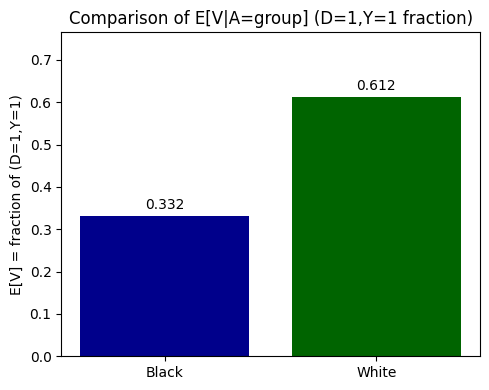

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


optimal_threshold = 0.6666667

# Predicted probabilities per group
y_prob_black = model.predict_proba(X_test[is_black])[:, 1]
y_prob_white = model.predict_proba(X_test[is_white])[:, 1]

# Binary decisions using the optimal threshold
y_pred_black = (y_prob_black >= optimal_threshold).astype(int)
y_pred_white = (y_prob_white >= optimal_threshold).astype(int)

# Actual outcomes per group
y_true_black = y_test[is_black]
y_true_white = y_test[is_white]


# Number of individuals in each group
n_black = len(y_true_black)
n_white = len(y_true_white)

# Count how many in each group have (D=1, Y=1)
count_black_d1y1 = np.sum((y_pred_black == 1) & (y_true_black == 1))
count_white_d1y1 = np.sum((y_pred_white == 1) & (y_true_white == 1))

# E[V|A=black], E[V|A=white]
#   = fraction of individuals in that group that have D=1 and Y=1
E_V_black = count_black_d1y1 / n_black if n_black > 0 else 0
E_V_white = count_white_d1y1 / n_white if n_white > 0 else 0


def difference_of_proportions_test(count1, n1, count2, n2):
    """
    Computes a two-proportion z-test for whether two proportions differ significantly.
    
    Returns: (p1, p2, z_stat, p_value)
    """
    if n1 == 0 or n2 == 0:
        # degenerate case
        return 0, 0, 0, 1
    
    p1 = count1 / n1
    p2 = count2 / n2
    pooled = (count1 + count2) / (n1 + n2)
    
    # Standard error for difference of proportions
    se = np.sqrt(pooled * (1 - pooled) * (1/n1 + 1/n2))
    if se == 0:
        z_stat = 0
        p_value = 1
    else:
        z_stat = (p1 - p2) / se
        # Two-sided p-value
        p_value = 2 * (1 - norm.cdf(abs(z_stat)))
    return p1, p2, z_stat, p_value

p_black, p_white, z_stat, p_value = difference_of_proportions_test(
    count_black_d1y1, n_black,
    count_white_d1y1, n_white
)

difference = p_black - p_white

print("=== Fairness Criterion Check (No Justifier) ===")
print(f"Threshold used: {optimal_threshold}")
print(f"E[V|A=Black] = {E_V_black:.4f} (n_black={n_black})")
print(f"E[V|A=White] = {E_V_white:.4f} (n_white={n_white})")
print(f"Difference    = {difference:.4f}")

print("\nTwo-proportion z-test for difference in E[V]:")
print(f"   z-statistic = {z_stat:.4f}")
print(f"   p-value     = {p_value:.8f}")
if p_value < 0.05:
    print("=> Statistically significant difference at alpha=0.05")
else:
    print("=> No statistically significant difference at alpha=0.05")

#quick bar chart
groups = ['Black', 'White']
values = [E_V_black, E_V_white]

plt.figure(figsize=(5,4))
bars = plt.bar(groups, values, color=['darkblue','darkgreen'])

# Annotate each bar with numeric value
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01,
             f"{height:.3f}",
             ha='center', va='bottom', color='black')

plt.title("Comparison of E[V|A=group] (D=1,Y=1 fraction)")
plt.ylabel("E[V] = fraction of (D=1,Y=1)")
plt.ylim([0, max(values)*1.25])
plt.tight_layout()
plt.show()


# Task 5: Trade-off between DM utility and DS fairness

In [22]:
import numpy as np
import pandas as pd

###############################################################################
# 1) Compute model scores on X_test (probability of Y=1)
###############################################################################
scores_all = model.predict_proba(X_test)[:, 1]

###############################################################################
# 2) Convert y_test to numpy array if needed
###############################################################################
Y_all = np.array(y_test).astype(int)  # ensure it's 0/1 integers

###############################################################################
# 3) Determine the sensitive-attribute
#    Here: black => 1, white => 0
###############################################################################
sensitive_attr_all = np.where(is_black, 1, 0).astype(int)

###############################################################################
# 4) Generate the binary decisions D using your optimal threshold
###############################################################################
optimal_threshold = 0.6666667
D_all = (scores_all >= optimal_threshold).astype(int)

###############################################################################
# 5) Create the DataFrame with the required columns
###############################################################################
df_fairlab = pd.DataFrame({
    'Y': Y_all,                        # ground-truth label (0/1)
    'sensitive-attribute': sensitive_attr_all,  # 0 or 1
    'scores': scores_all,              # continuous scores in [0,1]
    'D': D_all                         # final binary decision
})

###############################################################################
# 6) Save to CSV
###############################################################################
df_fairlab.to_csv("fairnesslab_input.csv", index=False)

print("Saved 'fairnesslab_input.csv' with columns [Y, sensitive-attribute, scores, D].")


Saved 'fairnesslab_input.csv' with columns [Y, sensitive-attribute, scores, D].


# Task 6: Deployment 4 years later

In [23]:
data_source_deploy = ACSDataSource(survey_year=deployment_year, horizon=deployment_horizon, survey='person')
acs_deploy = data_source_deploy.get_data(states=[deployment_state], download=True)
features_deploy, label_deploy, group_deploy = ACSEmployment.df_to_numpy(acs_deploy)

yhat_deploy = model.predict(features_deploy)
scores_deploy = model.predict_proba(features_deploy)[:,1]

Task 1: Accuracy on 2018 data (threshold=0.5) = 0.657547301380689
Calibration bins (avg predicted vs observed) on 2018 data:
Bin 1, predicted=0.044, observed=0.16527731466044238
Bin 2, predicted=0.151, observed=0.13432175260013277
Bin 3, predicted=0.254, observed=0.1611155167856199
Bin 4, predicted=0.351, observed=0.26524559777571827
Bin 5, predicted=0.456, observed=0.222491393599388
Bin 6, predicted=0.555, observed=0.2403727664818238
Bin 7, predicted=0.651, observed=0.38418108906711695
Bin 8, predicted=0.751, observed=0.5968164161459213
Bin 9, predicted=0.851, observed=0.8112209535621785
Bin 10, predicted=0.919, observed=0.8825410063942174


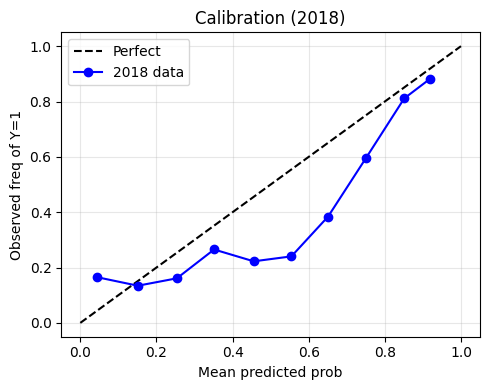


Task 2: Group-based metrics at threshold=0.5 [2018 data]
Black jobseekers: {'BR': np.float64(0.3794987528210001), 'PR': np.float64(0.5105119372847131), 'TPR': np.float64(0.8003129890451329), 'FNR': np.float64(0.1996870109545541), 'FPR': np.float64(0.3332695252679301), 'TNR': np.float64(0.6667304747318784)}
White jobseekers: {'BR': np.float64(0.4765265500456613), 'PR': np.float64(0.7606195749510138), 'TPR': np.float64(0.9387861422245203), 'FNR': np.float64(0.061213857775461226), 'FPR': np.float64(0.5984315983807761), 'TNR': np.float64(0.401568401619207)}


C:\Users\james\AppData\Local\Temp\ipykernel_26564\2674033481.py:135: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if util_t > best_util:



Task 3: Best threshold for DM utility on 2018 data = 0.000
        Corresponding utility=-inf

Task 4: DS fairness check with new best threshold [2018 data]


TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from folktables import ACSDataSource, ACSEmployment

###############################################################################
# Task 6: Evaluate on 2018 data (no train-test split)
# We'll do tasks 1-5 in one go.
###############################################################################

# -----------------------------
# 0) Fetch the 2018 data exactly as you described:
deployment_year = 2018
deployment_horizon = '1-Year'
deployment_state = 'PA'  # Example: Pennsylvania. Adjust if needed.

data_source_deploy = ACSDataSource(
    survey_year=deployment_year,
    horizon=deployment_horizon,
    survey='person'
)
acs_deploy = data_source_deploy.get_data(states=[deployment_state], download=True)
features_deploy, label_deploy, group_deploy = ACSEmployment.df_to_numpy(acs_deploy)

# Prepare predictions from the same model:
yhat_deploy = model.predict(features_deploy)          # threshold=0.5 by default
scores_deploy = model.predict_proba(features_deploy)[:, 1]

# For convenience:
Y_2018 = label_deploy       # ground truth
scores_2018 = scores_deploy # predicted probability
D_2018_05 = yhat_deploy     # decisions with default 0.5 threshold

# We'll assume group_deploy is 0=white, 1=black. If reversed, adjust below line.
is_black_2018 = (group_deploy == 2)
is_white_2018 = (group_deploy == 1)

###############################################################################
# 1) Model Performance on 2018 data
###############################################################################
accuracy_05 = np.mean(D_2018_05 == Y_2018)
print("Task 1: Accuracy on 2018 data (threshold=0.5) =", accuracy_05)

# Mini calibration check (10 bins)
bins = np.linspace(0, 1, 11)
bin_indices = np.digitize(scores_2018, bins) - 1
bin_indices = np.clip(bin_indices, 0, 9)

cal_x = []
cal_y = []
for i in range(10):
    mask = (bin_indices == i)
    count_i = np.sum(mask)
    if count_i > 0:
        cal_x.append(np.mean(scores_2018[mask]))
        cal_y.append(np.mean(Y_2018[mask]))
    else:
        cal_x.append((bins[i]+bins[i+1])/2)
        cal_y.append(np.nan)

print("Calibration bins (avg predicted vs observed) on 2018 data:")
for i in range(10):
    print(f"Bin {i+1}, predicted={cal_x[i]:.3f}, observed={cal_y[i] if not np.isnan(cal_y[i]) else 'NoData'}")

# (Optional) plot calibration curve
plt.figure(figsize=(5,4))
plt.plot([0,1],[0,1],'k--',label='Perfect')
valid = ~np.isnan(cal_y)
plt.plot(np.array(cal_x)[valid], np.array(cal_y)[valid], 'bo-', label='2018 data')
plt.title("Calibration (2018)")
plt.xlabel("Mean predicted prob")
plt.ylabel("Observed freq of Y=1")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

###############################################################################
# 2) Group metrics on 2018 data at threshold=0.5
###############################################################################
def quick_metrics(y_true, y_pred):
    eps = 1e-9
    br = np.mean(y_true)
    pr = np.mean(y_pred)
    tp = np.sum((y_true==1)&(y_pred==1))
    fn = np.sum((y_true==1)&(y_pred==0))
    fp = np.sum((y_true==0)&(y_pred==1))
    tn = np.sum((y_true==0)&(y_pred==0))
    tpr = tp/(tp+fn+eps)
    fnr = fn/(tp+fn+eps)
    fpr = fp/(fp+tn+eps)
    tnr = tn/(fp+tn+eps)
    return {
        'BR': br, 'PR': pr,
        'TPR': tpr, 'FNR': fnr,
        'FPR': fpr, 'TNR': tnr
    }

y_pred_black_05 = D_2018_05[is_black_2018]
y_true_black_05 = Y_2018[is_black_2018]
met_black_05 = quick_metrics(y_true_black_05, y_pred_black_05)

y_pred_white_05 = D_2018_05[is_white_2018]
y_true_white_05 = Y_2018[is_white_2018]
met_white_05 = quick_metrics(y_true_white_05, y_pred_white_05)

print("\nTask 2: Group-based metrics at threshold=0.5 [2018 data]")
print("Black jobseekers:", met_black_05)
print("White jobseekers:", met_white_05)

###############################################################################
# 3) Recompute best threshold for DM utility on 2018 data (same DM utility)
###############################################################################
# Example DM utility from prior tasks
U = np.array([
    [-60000, -60000],  # U[D=0, Y=0], U[D=0, Y=1]
    [-80000, -50000]   # U[D=1, Y=0], U[D=1, Y=1]
], dtype=float)

def ds_utility_avg(y_true, scores, threshold, Vmat, group_mask):
    D = (scores >= threshold).astype(int)
    idx = np.where(group_mask)[0]
    if len(idx) == 0:
        return np.nan
    total_v = 0.0
    for i in idx:
        d_i = D[i]
        y_i = y_true[i]
        total_v += Vmat[d_i, y_i]

    # Return a float, not an array
    return float(total_v / len(idx))


best_threshold = 0.0
best_util = float('-inf')
for t in np.linspace(0,1,101):
    util_t = dm_utility_avg(Y_2018, scores_2018, t, U)
    if util_t > best_util:
        best_util = util_t
        best_threshold = t

print(f"\nTask 3: Best threshold for DM utility on 2018 data = {best_threshold:.3f}")
print(f"        Corresponding utility={best_util:.2f}")

###############################################################################
# 4) DS fairness criterion with new threshold
#    DS utility matrix from tasks: V = [[0,0],[0,1]]
###############################################################################
V = np.array([[0,0],[0,1]], dtype=float)

def ds_utility_avg(y_true, scores, threshold, Vmat, group_mask):
    D = (scores >= threshold).astype(int)
    idx = np.where(group_mask)[0]
    if len(idx)==0:
        return np.nan
    sum_v = 0.0
    for i in idx:
        d_i = D[i]
        y_i = y_true[i]
        sum_v += Vmat[d_i, y_i]
    return sum_v/len(idx)

E_V_black = ds_utility_avg(Y_2018, scores_2018, best_threshold, V, is_black_2018)
E_V_white = ds_utility_avg(Y_2018, scores_2018, best_threshold, V, is_white_2018)

print("\nTask 4: DS fairness check with new best threshold [2018 data]")
print(f"E[V|black]={E_V_black:.4f}, E[V|white]={E_V_white:.4f}")
diff_ev = E_V_black - E_V_white
print(f"Difference (black - white)={diff_ev:.4f}")

# (Optional) difference-of-proportions test
D_best_2018 = (scores_2018 >= best_threshold).astype(int)
idx_black = np.where(is_black_2018)[0]
idx_white = np.where(is_white_2018)[0]
count_black_d1y1 = np.sum((D_best_2018[idx_black]==1)&(Y_2018[idx_black]==1))
count_white_d1y1 = np.sum((D_best_2018[idx_white]==1)&(Y_2018[idx_white]==1))
n_black = len(idx_black)
n_white = len(idx_white)

def diff_prop_test(success1, n1, success2, n2):
    p1 = success1/n1
    p2 = success2/n2
    pooled = (success1+success2)/(n1+n2)
    se = np.sqrt(pooled*(1-pooled)*(1/n1+1/n2))
    if se<1e-15:
        return 0,1
    z = (p1-p2)/se
    pval=2*(1-norm.cdf(abs(z)))
    return z,pval

z_val, p_val = diff_prop_test(count_black_d1y1, n_black, count_white_d1y1, n_white)
print(f"Z-stat for difference-of-proportions: {z_val:.3f}, p-value={p_val:.5f}")
if p_val<0.05:
    print("=> Statistically significant difference in DS utility across groups.")
else:
    print("=> No statistically significant difference at alpha=0.05.")

###############################################################################
# 5) (Optional) Prepare CSV for FairnessLab with 2018 data 
#     if you want group-specific thresholds again
###############################################################################
df_fairlab_2018 = pd.DataFrame({
    'Y': Y_2018.astype(int),
    'sensitive-attribute': group_deploy.astype(int),
    'scores': scores_2018,
    'D': (scores_2018 >= best_threshold).astype(int)
})
df_fairlab_2018.to_csv("fairnesslab_input_2018.csv", index=False)

print("\nTask 5: Wrote 'fairnesslab_input_2018.csv' for group-specific threshold analysis in FairnessLab on 2018 data.")
